Machine Learning Terapan - Proyek Akhir : Sistem Rekomendasi
- Nama : Attiya Dianti Fadli
- ID : MC189D5X0806

# 1. Import Library yang Dibutuhkan

In [ ]:
!pip install -q kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from google.colab import files
from sklearn.preprocessing import LabelEncoder

mengimport semua library yang dibutuhkan dalam proyek

# 2. Data Understanding

data diambil dari [Kaggle](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination)

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"attiyadiantifadli","key":"edb0d362ff64c61df6bdec29f5e6d316"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 109MB/s]


In [ ]:
!unzip indonesia-tourism-destination.zip

Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


terdapat empat file csv. namun, untuk proyek ini hanya menggunakan `tourism_rating.csv` dan `tourism_with_id.csv`

In [ ]:
!mv '/content/tourism_with_id.csv' 'data.csv'
!mv '/content/tourism_rating.csv' 'rating.csv'

#Menghapus file yang tidak dibutuhkan
!rm indonesia-tourism-destination.zip
!rm package_tourism.csv
!rm user.csv

mengubah nama file agar lebih mudah digunakan dan menghapus file yang tidak dibutuhkan

- `tourism_rating.csv` — Berisi data rating destinasi pariwisata oleh pengguna.
- `tourism_with_id.csv` — Berisi informasi destinasi dengan ID unik yang dapat digunakan untuk relasi atau referensi.

In [ ]:
data = pd.read_csv('data.csv')
rating = pd.read_csv('rating.csv')

membaca dan menyimpan dataset dalam variabel

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


menampilkan informasi dari variabel data
- Total baris ada 437
- Total kolom ada 13
- Terdapat 8 kolom bertipe data numerik
- Terdapat 5 kolom bertipe data object

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


menampilkan informasi dari variabel rating
- Total baris ada 10000
- Total kolom ada 3
- Semua kolom bertipe numerik

In [ ]:
data.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


menampilkan 5 data teratas dari variabel data

In [ ]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


menampilkan 5 data teratas dari variabel rating

# 3. Univariate Exploratory Data Analysis

1. data:
- `Place_Id`: ID unik untuk setiap destinasi wisata.
- `Place_Name`: Nama tempat atau destinasi wisata.
- `Description`: Deskripsi singkat mengenai tempat wisata tersebut.
- `Category`: Kategori wisata (misalnya alam, budaya, sejarah, dll).
- `City`: Kota tempat destinasi tersebut berada.
- `Price`: Estimasi biaya tiket masuk atau biaya kunjungan (dalam Rupiah).
- `Rating`: Rating rata-rata destinasi berdasarkan penilaian pengunjung (skala biasanya 1–5).
- `Time_Minutes`: Estimasi durasi kunjungan (dalam menit); nilai bisa kosong pada beberapa tempat.
- `Coordinate`: Lokasi geografis gabungan dalam bentuk teks (biasanya latitude,longitude).
- `Lat`: Latitude dari lokasi tempat wisata.
- `Long`: Longitude dari lokasi tempat wisata.
- `Unnamed`: 11: Kolom kosong
- `Unnamed`: 12: Kolom kosong

2. rating
- `User_Id`: ID unik untuk setiap pengguna.
- `Place_Id`: ID tempat wisata yang dirating (mengacu pada Place_Id di tourism_with_id.csv).
- `Place_Ratings`: Nilai rating yang diberikan pengguna terhadap tempat tertentu (skala biasanya 1–5).

**Variabel Data**

In [ ]:
data.head(1)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1


menampilkan 1 kolom dari variabel data

In [ ]:
# Hitung jumlah nama tempat unik
print('Jumlah Nama Tempat Unik:', data['Place_Name'].nunique())
place_id_name = data.drop_duplicates(subset=['Place_Id'])[['Place_Id', 'Place_Name']].set_index('Place_Id')

# Hitung jumlah kemunculan masing-masing Place_Id
place_id_counts = data['Place_Id'].value_counts()
place_summary = place_id_name.join(place_id_counts.rename('Jumlah'))
place_summary = place_summary.sort_index()
place_summary = place_summary[['Place_Name', 'Jumlah']]
place_summary = place_summary.reset_index()
print(place_summary.to_string(index=False))

Jumlah Nama Tempat Unik: 437
 Place_Id                                              Place_Name  Jumlah
        1                                        Monumen Nasional       1
        2                                                Kota Tua       1
        3                                           Dunia Fantasi       1
        4                       Taman Mini Indonesia Indah (TMII)       1
        5                                Atlantis Water Adventure       1
        6                                 Taman Impian Jaya Ancol       1
        7                                  Kebun Binatang Ragunan       1
        8                                           Ocean Ecopark       1
        9                                        Pelabuhan Marina       1
       10                                            Pulau Tidung       1
       11                                          Pulau Bidadari       1
       12                                              Pulau Pari       1
       13

total nama tempat unik: 437 <br> Data menunjukkan keragaman tempat wisata dengan fokus pada pengalaman yang unik di setiap lokasi.

Jumlah Kategori Wisata: 6
Category
Taman Hiburan         135
Budaya                117
Cagar Alam            106
Bahari                 47
Tempat Ibadah          17
Pusat Perbelanjaan     15
Name: count, dtype: int64


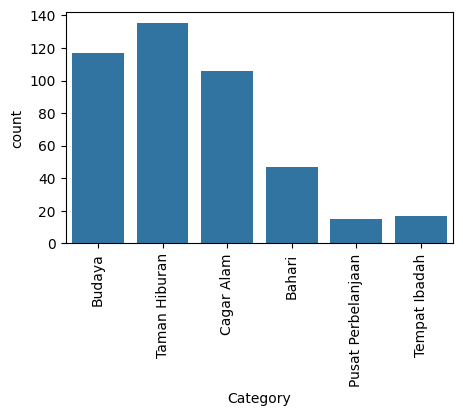

In [ ]:
print('Jumlah Kategori Wisata:', data['Category'].nunique())
category_counts = data['Category'].value_counts()
print(category_counts)

#Menampilkan dalam bentuk grafik
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x=data['Category'])
plt.xticks(rotation=90)
plt.show()

jumlah kunjungan ke berbagai jenis tempat. Kategori Budaya mencatat jumlah kunjungan tertinggi, yaitu 130, diikuti oleh Taman Hiburan dengan total 120 kunjungan. Selanjutnya, Cagar Alam menunjukkan angka yang lebih rendah, sekitar 70 kunjungan, sementara Bahari memiliki 40 kunjungan. Terakhir, Pusat Pembelajaran dan Tempat Ibadah masing-masing hanya mendapatkan sekitar 20 kunjungan, yang merupakan jumlah terendah di antara semua kategori.

Jumlah Daerah: 5
City
Yogyakarta    126
Bandung       124
Jakarta        84
Semarang       57
Surabaya       46
Name: count, dtype: int64


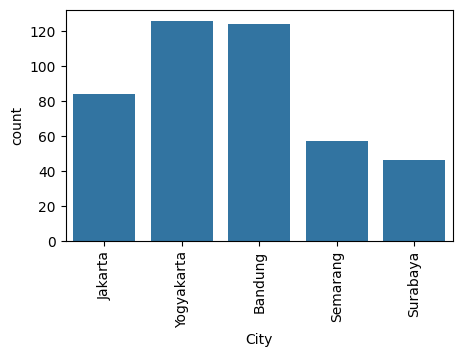

In [ ]:
print('Jumlah Daerah:', data['City'].nunique())
city_counts = data['City'].value_counts()
print(city_counts)

#Menampilkan dalam bentuk grafik
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x=data['City'])
plt.xticks(rotation=90)
plt.show()

 jumlah kunjungan ke beberapa kota. Kategori Yogyakarta mencatat jumlah kunjungan tertinggi, mencapai 130. Diikuti oleh Bandung dengan total 120 kunjungan. Jakarta juga memiliki angka yang signifikan, sekitar 90 kunjungan. Sementara itu, Semarang mencatat sekitar 60 kunjungan, dan Surabaya memiliki jumlah terendah dengan sekitar 50 kunjungan.

In [ ]:
print('Harga minimum:', data['Price'].min())
print('Harga maksimum:', data['Price'].max())

price_counts = data['Price'].value_counts()
print(price_counts)

Harga minimum: 0
Harga maksimum: 900000
Price
0         137
10000      52
5000       51
15000      24
50000      19
20000      16
25000      15
3000       15
2000       14
30000       8
2500        7
35000       6
40000       6
7500        6
75000       5
150000      5
7000        4
100000      3
4000        3
6000        3
60000       2
1000        2
200000      2
175000      2
180000      2
185000      2
70000       2
12000       2
110000      1
270000      1
94000       1
115000      1
900000      1
300000      1
250000      1
22000       1
220000      1
500000      1
8000        1
280000      1
81000       1
45000       1
375000      1
11000       1
23000       1
80000       1
9000        1
5500        1
95000       1
125000      1
Name: count, dtype: int64


Ringkasan Statistik
- Rentang Harga: Rp 0 - Rp 900.000
- Harga minimum: 0
- Harga maksimum: 900000

Jumlah Durasi Wisata: 15
Time_Minutes
90.0     43
60.0     40
45.0     33
120.0    28
30.0     20
150.0    12
180.0     9
15.0      8
20.0      3
210.0     2
240.0     2
25.0      2
300.0     1
360.0     1
10.0      1
Name: count, dtype: int64


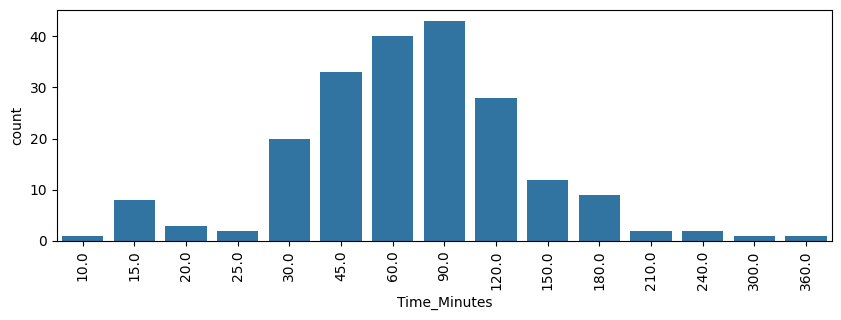

In [ ]:
print('Jumlah Durasi Wisata:', data['Time_Minutes'].nunique())
time_counts = data['Time_Minutes'].value_counts()
print(time_counts)

#Menampilkan dalam bentuk grafik
plt.figure(figsize=(10, 3))
sns.countplot(data=data, x=data['Time_Minutes'])
plt.xticks(rotation=90)
plt.show()

distribusi durasi wisata dalam satuan menit. Durasi sekitar 90 menit memiliki jumlah kunjungan tertinggi, mencapai 40. Kategori durasi 60 menit juga menunjukkan angka yang signifikan, dengan sekitar 35 kunjungan. Selain itu, durasi 45 menit dan 120 menit masing-masing mencatat sekitar 30 dan 25 kunjungan. Sementara itu, durasi yang lebih pendek, seperti 10 menit dan 15 menit, memiliki jumlah kunjungan yang jauh lebih rendah, menunjukkan bahwa pengunjung cenderung memilih durasi yang lebih lama untuk pengalaman wisata mereka.

In [ ]:
print('Jumlah koordinat unik:', data['Coordinate'].nunique())
koor_counts = data['Coordinate'].value_counts()
print(koor_counts)

Jumlah koordinat unik: 437
Coordinate
{'lat': -7.2420758, 'lng': 112.7368158}            1
{'lat': -6.1753924, 'lng': 106.8271528}            1
{'lat': -6.137644799999999, 'lng': 106.8171245}    1
{'lat': -6.125312399999999, 'lng': 106.8335377}    1
{'lat': -6.302445899999999, 'lng': 106.8951559}    1
                                                  ..
{'lat': -5.803205300000001, 'lng': 106.5237907}    1
{'lat': 1.07888, 'lng': 103.931398}                1
{'lat': -6.125801699999999, 'lng': 106.8363249}    1
{'lat': -6.3124593, 'lng': 106.8201865}            1
{'lat': -6.117333200000001, 'lng': 106.8579951}    1
Name: count, Length: 437, dtype: int64


data menunjukkan **437 lokasi unik** dengan distribusi merata (1 entri per koordinat). Sebaran terpusat di **Jakarta-Bogor** area (lat -6.1 sampai -6.3, lng ~106.8) dengan beberapa titik di **Surabaya** dan **Singapura**. Pola ini mengindikasikan **cakupan geografis luas** namun **tidak ada clustering** - kemungkinan strategi distribusi merata atau early-stage expansion.

Range Latitude: -8.1978943 sampai 1.07888
Range Longitude: 103.931398 sampai 112.8216622


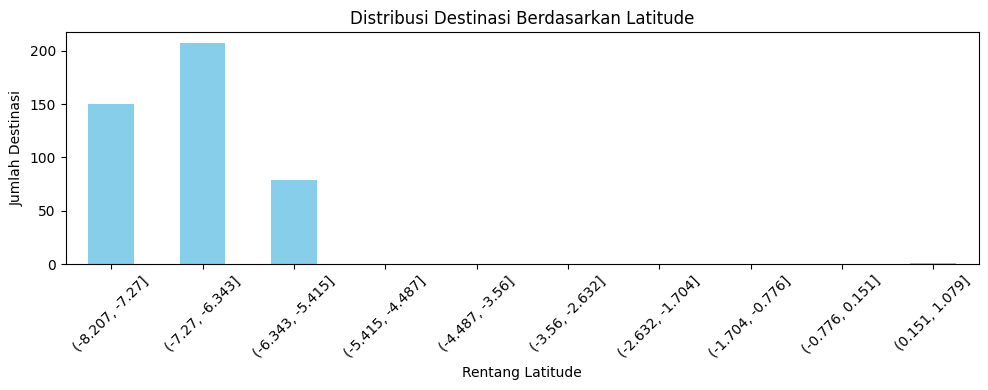

In [ ]:
print('Range Latitude:', data['Lat'].min(), 'sampai', data['Lat'].max())
print('Range Longitude:', data['Long'].min(), 'sampai', data['Long'].max())

data['Lat_Bin'] = pd.cut(data['Lat'], bins=10)
lat_counts = data['Lat_Bin'].value_counts().sort_index()
plt.figure(figsize=(10, 4))
lat_counts.plot(kind='bar', color='skyblue')
plt.title('Distribusi Destinasi Berdasarkan Latitude')
plt.xlabel('Rentang Latitude')
plt.ylabel('Jumlah Destinasi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

distribusi jumlah destinasi berdasarkan rentang latitude. Rentang (-8.207, -7.727) mencatat jumlah destinasi tertinggi, mencapai lebih dari 200. Rentang (-7.727, -6.343) juga menunjukkan angka yang signifikan, dengan sekitar 150 destinasi. Selanjutnya, rentang (-6.343, -5.453) memiliki jumlah destinasi yang lebih rendah, sekitar 100. Rentang (-5.453, -4.487) dan (-4.487, -3.628) masing-masing mencatat jumlah yang lebih sedikit, sementara rentang terakhir (-1.704, -0.511) menunjukkan jumlah destinasi terendah.

**Variabel Rating**

In [ ]:
review_per_user = rating.groupby('User_Id').size()
print("Jumlah review per user:")
print(review_per_user)

Jumlah review per user:
User_Id
1      30
2      29
3      30
4      26
5      33
       ..
296    36
297    36
298    30
299    39
300    26
Length: 300, dtype: int64


data menunjukkan 300 user dengan aktivitas review yang sangat konsisten - mayoritas user memberikan 26-39 review per orang (rata-rata ~30 review). Distribusi yang merata ini mengindikasikan high engagement dan kemungkinan adanya sistem incentive atau requirement minimum untuk review, karena jarang terjadi pola seragam seperti ini secara natural di platform user-generated content.


Jumlah kemunculan per Place_Id (urut berdasarkan ID):
 Place_Id
1      18
2      25
3      19
4      21
5      25
       ..
433    23
434    25
435    17
436    22
437    38
Name: count, Length: 437, dtype: int64

Place_Id dengan terdikit: [51, 175]
Place_Id dengan terbanyak: [298, 177]


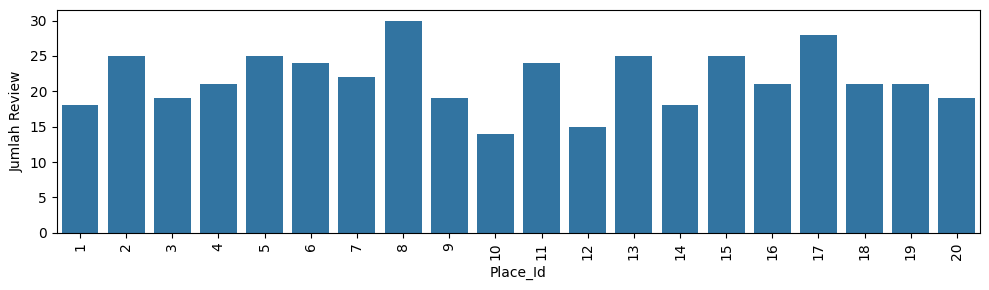

In [ ]:
place_review_counts = rating['Place_Id'].value_counts()

# Cetak jumlah berdasarkan urutan Place_Id
print("\nJumlah kemunculan per Place_Id (urut berdasarkan ID):\n", place_review_counts.sort_index())

# Statistik jumlah review
min_count = place_review_counts.min()
max_count = place_review_counts.max()

min_place_id = place_review_counts[place_review_counts == min_count].index.tolist()
max_place_id = place_review_counts[place_review_counts == max_count].index.tolist()

print(f"\nPlace_Id dengan terdikit: {min_place_id}")
print(f"Place_Id dengan terbanyak: {max_place_id}")

# Ambil 20 Place_Id teratas berdasarkan ID (bukan jumlah review)
top_20_places = place_review_counts.sort_index().head(20)

# Plot barplot dengan Place_Id di sumbu X dan jumlah review di sumbu Y
plt.figure(figsize=(10, 3))
sns.barplot(x=top_20_places.index, y=top_20_places.values)
plt.xticks(rotation=90)
plt.xlabel('Place_Id')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

distribusi kemunculan berdasarkan Place_Id yang diurutkan berdasarkan ID. Place_Id 8 mencatat jumlah review tertinggi, mencapai sekitar 30. Beberapa Place_Id lain, seperti 7 dan 17, juga menunjukkan angka yang signifikan dengan sekitar 25 review. Sebagian besar ID lainnya memiliki jumlah review yang relatif seimbang, berkisar antara 10 hingga 20. Secara keseluruhan, grafik ini mencerminkan variasi dalam jumlah review untuk setiap tempat.

Jumlah total rating: 10000
Rating unik: [3 2 5 4 1]
Distribusi rating:
 Place_Ratings
1    1706
2    2071
3    2096
4    2106
5    2021
Name: count, dtype: int64
Rata-rata rating: 3.0665


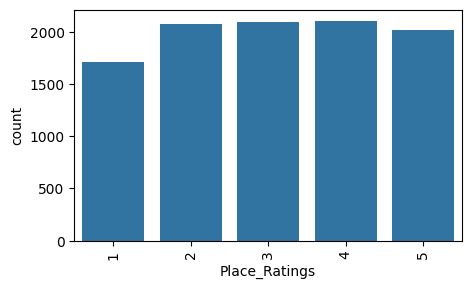

In [ ]:
print('Jumlah total rating:', rating['Place_Ratings'].count())
print('Rating unik:', rating['Place_Ratings'].unique())
print('Distribusi rating:\n', rating['Place_Ratings'].value_counts().sort_index())
print('Rata-rata rating:', rating['Place_Ratings'].mean())

#Menampilkan dalam bentuk grafik
plt.figure(figsize=(5, 3))
sns.countplot(data=rating, x=rating['Place_Ratings'])
plt.xticks(rotation=90)
plt.show()

distribusi rating berdasarkan Place_Ratings. Rating 2 tercatat sebagai yang tertinggi, dengan jumlah sekitar 2000. Rating 3, 4, dan 5 juga menunjukkan angka yang signifikan, masing-masing berada di kisaran yang sama. Namun, rating 1 memiliki jumlah yang jauh lebih rendah dibandingkan dengan rating lainnya. Secara keseluruhan, grafik ini mencerminkan bahwa sebagian besar rating berkisar di antara 2 hingga 5, dengan sedikit penilaian yang sangat rendah.

# 4. Data Preprocessing

menggabungkan dataset variabel data dan variabel rating

In [ ]:
# Gabungkan data rating dengan informasi tempat berdasarkan 'Place_Id'
merged_data = pd.merge(rating, data, on='Place_Id')

# Tampilkan hasil gabungan
merged_data.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12,Lat_Bin
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,Yogyakarta,75000,4.6,90.0,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416,NaN,179,"(-8.207, -7.27]"
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,Semarang,3000,4.1,NaN,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329,NaN,344,"(-7.27, -6.343]"
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5,"(-6.343, -5.415]"
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5,60.0,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,NaN,373,"(-7.27, -6.343]"
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0,4.0,NaN,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151,NaN,101,"(-8.207, -7.27]"


menghapus kolom yang tidak di perlukan dalam dataset

In [ ]:
# Hapus kolom-kolom yang tidak relevan
merged_data = merged_data.drop(columns=['City', 'Price', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12', 'Lat_Bin'])

# Tampilkan hasil setelah kolom dihapus
merged_data.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,Rating
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,4.6
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,4.1
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,4.5
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,4.5
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,4.0


pada proyek ini hanya menggunakan kolom `User_Id`, `Place_Id`, `Place_Ratings`, `Place_Name`, `Description`, `Category`, dan `Rating`

mengecek missing value

In [ ]:
merged_data.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0
Place_Name,0
Description,0
Category,0
Rating,0


tidak terdapat missing value

menampilkan dataset yang sudah dibersihkan

In [ ]:
dataset = merged_data
dataset

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,Rating
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,4.6
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,4.1
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,4.5
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,4.5
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,4.0
...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Waterpark Kenjeran Surabaya merupakan wisata k...,Taman Hiburan,4.1
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Budaya,4.7
9997,300,311,3,The Lodge Maribaya,The Lodge Maribaya adalah salah satu tempat wi...,Cagar Alam,4.3
9998,300,279,4,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Tempat Ibadah,4.8


# 5. Data Preparation

menghapus data duplikat berdasarkan Place_Id

In [ ]:
dataset = dataset.drop_duplicates('Place_Id')

melakukan konversi data Series menjadi list

In [ ]:
# Konversi beberapa kolom dari Series menjadi list
place_id_list = dataset['Place_Id'].tolist()
place_name_list = dataset['Place_Name'].tolist()
user_id_list = dataset['User_Id'].tolist()
place_rating_list = dataset['Place_Ratings'].tolist()

# Tampilkan panjang dari setiap list
print(len(place_id_list))
print(len(place_name_list))
print(len(user_id_list))
print(len(place_rating_list))

437
437
437
437


konsistensi data sempurna - semua kolom memiliki 437 records tanpa missing values, mengindikasikan dataset yang clean dan well-structured. Konversi ke list format ini biasanya dilakukan untuk persiapan modeling (seperti recommendation system) atau data processing yang membutuhkan struktur array/list dibanding DataFrame.

In [ ]:
# Pilih kolom bertipe object (biasanya berisi teks)
text_columns = dataset.select_dtypes(include='object').columns.tolist()

# Tambahkan kolom 'Place_Id' secara manual jika belum ada
if 'Place_Id' not in text_columns:
    text_columns.append('Place_Id')

# Buat dictionary dari kolom yang dipilih (konversi ke string untuk jaga-jaga)
place_text_dict = {col: dataset[col].astype(str).tolist() for col in text_columns}

# Buat DataFrame baru dari dictionary
place_text_df = pd.DataFrame(place_text_dict)

# Pastikan 'Place_Id' menjadi kolom pertama
cols = ['Place_Id'] + [col for col in place_text_df.columns if col != 'Place_Id']
place_text_df = place_text_df[cols]

# Tampilkan hasil
print("Kolom teks yang digunakan:", cols)
place_text_df.head()

Kolom teks yang digunakan: ['Place_Id', 'Place_Name', 'Description', 'Category']


,Place_Id,Place_Name,Description,Category
0,179,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya
1,344,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari
2,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan
3,373,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya
4,101,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya


4 kolom text features: Place_Id, Place_Name, Description, dan Category yang akan digunakan untuk content-based filtering. Data mencakup berbagai kategori wisata (Budaya, Bahari, Taman Hiburan) dengan deskripsi lengkap dalam bahasa Indonesia dan Jawa, mengindikasikan dataset tourism places yang rich in content untuk recommendation modeling.

# 6. Model Development Dengan Content Based Filtering

Melakukan assign dataframe ke variabel baru yaitu data.

In [ ]:
data = place_text_df

Membangun sistem rekomendasi.

In [ ]:
tfidf = TfidfVectorizer()

# Latih model vektor pada data dengan kolom category
tfidf.fit(data['Category'])

# Tampilkan nama-nama fitur hasil vektorisasi
fitur_tfidf = tfidf.get_feature_names_out()
print("Fitur hasil ekstraksi:", fitur_tfidf[:10])

Fitur hasil ekstraksi: ['alam' 'bahari' 'budaya' 'cagar' 'hiburan' 'ibadah' 'perbelanjaan'
 'pusat' 'taman' 'tempat']


melakukan fit dan transformasi ke TF-IDF matrix

In [ ]:
# Transformasi teks gabungan ke dalam representasi vektor TF-IDF
matriks_tfidf = tfidf.transform(data['Category'])

# Tampilkan dimensi matriks hasil transformasi
print("Ukuran matriks TF-IDF:", matriks_tfidf.shape)

Ukuran matriks TF-IDF: (437, 10)


membuat vektor TF-IDF dalam bentuk matriks

In [ ]:
matriks_tfidf.todense()

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ]])

membuat matriks TF-IDF untuk beberapa model dan category

In [ ]:
# Konversi TF-IDF matrix ke dalam DataFrame untuk ditampilkan
df_tfidf = pd.DataFrame(
    matriks_tfidf.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=place_text_df['Category']
)

# Tampilkan secara acak 10 baris & 10 kolom agar tidak tampil penuh
sampel_tfidf = df_tfidf.sample(n=10, axis=0).sample(n=10, axis=1)
print("Matriks TF-IDF:")
sampel_tfidf

Matriks TF-IDF:


,pusat,perbelanjaan,taman,bahari,budaya,tempat,cagar,ibadah,hiburan,alam
Category,,,,,,,,,,
Budaya,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
Cagar Alam,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.707107,0.000000,0.000000,0.707107
Tempat Ibadah,0.000000,0.000000,0.000000,0.0,0.0,0.707107,0.000000,0.707107,0.000000,0.000000
Budaya,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
Tempat Ibadah,0.000000,0.000000,0.000000,0.0,0.0,0.707107,0.000000,0.707107,0.000000,0.000000
Taman Hiburan,0.000000,0.000000,0.707107,0.0,0.0,0.000000,0.000000,0.000000,0.707107,0.000000
Pusat Perbelanjaan,0.707107,0.707107,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Taman Hiburan,0.000000,0.000000,0.707107,0.0,0.0,0.000000,0.000000,0.000000,0.707107,0.000000
Bahari,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


Menghitung derajat kesamaan (similarity degree) teknik cosine similarity.

In [ ]:
# Hitung cosine similarity antar baris pada matriks TF-IDF
kemiripan_tempat = cosine_similarity(matriks_tfidf)

# Konversi hasil similarity ke bentuk DataFrame agar mudah dibaca
df_kemiripan = pd.DataFrame(
    kemiripan_tempat,
    index=place_text_df['Place_Name'],
    columns=place_text_df['Category']
)

# Tampilkan sebagian kecil hasil
print("Contoh nilai kesamaan antar tempat wisata:")
df_kemiripan.iloc[:5, :5]

Contoh nilai kesamaan antar tempat wisata:


Category,Budaya,Bahari,Taman Hiburan,Budaya,Budaya
Place_Name,,,,,
Candi Ratu Boko,1.0,0.0,0.0,1.0,1.0
Pantai Marina,0.0,1.0,0.0,0.0,0.0
Atlantis Water Adventure,0.0,0.0,1.0,0.0,0.0
Museum Kereta Ambarawa,1.0,0.0,0.0,1.0,1.0
Kampung Wisata Sosro Menduran,1.0,0.0,0.0,1.0,1.0


membuat model rekomendasi


In [ ]:
# Ambil kolom kategori dan ubah ke string
kategori_teks = place_text_df['Category'].fillna('').astype(str)

# Buat vectorizer dan fit-transform
vector_kategori = TfidfVectorizer()
tfidf_kategori = vector_kategori.fit_transform(kategori_teks)

# Hitung similarity matrix berdasarkan kategori
similarity_kategori = cosine_similarity(tfidf_kategori)

# Buat fungsi rekomendasi berdasarkan nama tempat
def model_recommendations(nama_tempat, top_n=5):
    if nama_tempat not in place_text_df['Category'].values:
        print(f"'{nama_tempat}' tidak ditemukan dalam data.")
        return []

    # Temukan indeks tempat input
    idx = place_text_df[place_text_df['Category'] == nama_tempat].index[0]

    # Ambil skor similarity untuk tempat tersebut
    skor_kemiripan = list(enumerate(similarity_kategori[idx]))

    # Urutkan berdasarkan skor tertinggi (kecuali dirinya sendiri)
    rekomendasi = sorted(skor_kemiripan, key=lambda x: x[1], reverse=True)
    rekomendasi = [i for i in rekomendasi if i[0] != idx][:top_n]

    # Ambil nama tempat dari indeks hasil rekomendasi
    hasil = place_text_df.iloc[[i[0] for i in rekomendasi]]['Place_Name'].tolist()

    return hasil

melihat rekomendasi wisata untuk category taman hiburan

In [ ]:
model_recommendations('Taman Hiburan')

['Tugu Pal Putih Jogja',
 'Surabaya North Quay',
 'Grand Maerakaca',
 'Taman Cattleya',
 'Taman Pintar Yogyakarta']

model ini merekomendasikan
`Tugu Pal Putih Jogja`,
 `Surabaya North Quay`,
 `Grand Maerakaca`,
 `Taman Cattleya`,
 `Taman Pintar Yogyakarta` untuk categort `Taman Hiburan`



melihat rekomendasi wisata untuk category budaya

In [ ]:
model_recommendations('Budaya')

['Museum Kereta Ambarawa',
 'Kampung Wisata Sosro Menduran',
 'Museum Gedung Sate',
 'Museum Taman Prasasti',
 'De Mata Museum Jogja']

model ini merekomendasikan
`Museum Kereta Ambarawa`,
 `Kampung Wisata Sosro Menduran`,
 `Museum Gedung Sate`,
 `Museum Taman Prasasti`,
 `De Mata Museum Jogja` untuk categort `Budaya`


# 7. Model Model Development dengan Collaborative Filtering

Menyimpan dataset rating yang sudah pernah diread di variabel df.

In [ ]:
df = rating
df

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


Menyandikan (encode) kolom `User_Id`

In [ ]:
# Inisialisasi encoder
user_encoder = LabelEncoder()

# Terapkan encoding ke kolom user_id
dataset['user_id_enc'] = user_encoder.fit_transform(dataset['User_Id'])

# Tampilkan hasil encoding
dataset[['User_Id', 'user_id_enc']].drop_duplicates().head()

<ipython-input-41-d773173dee01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['user_id_enc'] = user_encoder.fit_transform(dataset['User_Id'])


,User_Id,user_id_enc
0,1,0
30,2,1
59,3,2
89,4,3
116,5,4


Menyandikan (encode) kolom `Place_Id`

In [ ]:
# Inisialisasi encoder
place_encoder = LabelEncoder()

# Terapkan encoding ke kolom user_id
dataset['place_id_enc'] = place_encoder.fit_transform(dataset['Place_Id'])

# Tampilkan hasil encoding
dataset[['Place_Id', 'place_id_enc']].drop_duplicates().head()

<ipython-input-42-b9bd1b94c4f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['place_id_enc'] = place_encoder.fit_transform(dataset['Place_Id'])


,Place_Id,place_id_enc
0,179,178
1,344,343
2,5,4
3,373,372
4,101,100


Menyandikan (encode) kolom `Place_Ratings`

In [ ]:
# Inisialisasi encoder
rating_encoder = LabelEncoder()

# Terapkan encoding ke kolom user_id
dataset['rating_id_enc'] = rating_encoder.fit_transform(dataset['Place_Ratings'])

# Tampilkan hasil encoding
dataset[['Place_Ratings', 'rating_id_enc']].drop_duplicates().head()

<ipython-input-43-f5bd3f4a8f2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['rating_id_enc'] = rating_encoder.fit_transform(dataset['Place_Ratings'])


,Place_Ratings,rating_id_enc
0,3,2
1,2,1
2,5,4
4,4,3
1706,1,0


Menampilkan jumlah user dan cellphone dan menampilkan nilai minimum dan maximum dari rating.

In [ ]:
# Jumlah unik pengguna dan tempat wisata
total_user = dataset['User_Id'].nunique()
total_tempat = dataset['Place_Id'].nunique()

print(f"Jumlah pengguna unik      : {total_user}")
print(f"Jumlah tempat wisata unik : {total_tempat}")

# Nilai minimum dan maksimum dari rating
nilai_min = dataset['Place_Ratings'].min()
nilai_maks = dataset['Place_Ratings'].max()

print(f"Rating terendah  : {nilai_min}")
print(f"Rating tertinggi : {nilai_maks}")

Jumlah pengguna unik      : 57
Jumlah tempat wisata unik : 437
Rating terendah  : 1
Rating tertinggi : 5


Mengacak dataset

In [ ]:
# Ambil semua kolom kecuali yang mengandung '_enc'
kolom_asli = [col for col in dataset.columns if not col.endswith('_enc')]

# Tampilkan hanya kolom asli
dataset[kolom_asli].head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,Rating
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,4.6
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,4.1
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,4.5
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,4.5
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,4.0


menggabungkan kolom user dan cellphone ke dalam array x, serta membuat array y untuk rating yang telah dinormalisasi, lalu membaginya menjadi train dan validasi

In [ ]:
# Ambil pasangan user dan place sebagai array fitur menggunakan encoded IDs
fitur_interaksi = dataset[['user_id_enc', 'place_id_enc']].values

# Normalisasi nilai rating (0–1)
min_nilai = dataset['Place_Ratings'].min()
max_nilai = dataset['Place_Ratings'].max()

nilai_rating = dataset['Place_Ratings'].apply(
    lambda skor: (skor - min_nilai) / (max_nilai - min_nilai)
).values

# Tentukan batas index 80%
batas_split = int(0.8 * len(dataset))

# Bagi ke dalam data pelatihan dan validasi
x_train, x_valid = fitur_interaksi[:batas_split], fitur_interaksi[batas_split:]
y_train, y_valid = nilai_rating[:batas_split], nilai_rating[batas_split:]

# Cetak sebagian kecil hasil
print("Contoh fitur gabungan (user_enc, place_enc):\n", x_train[:5]) # Tampilkan 5 baris pertama saja
print("Contoh rating terstandarisasi:\n", y_train[:5]) # Tampilkan 5 baris pertama saja

Contoh fitur gabungan (user_enc, place_enc):
 [[  0 178]
 [  0 343]
 [  0   4]
 [  0 372]
 [  0 100]]
Contoh rating terstandarisasi:
 [0.5  0.25 1.   0.5  0.75]


membuat model rekomendasi

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Flatten, Dot, Dense, Dropout, Concatenate

class RecommenderNet(Model):
    def __init__(self, total_user, total_place, dim_embedding=50):
        super(RecommenderNet, self).__init__()

        # Embedding layer untuk user
        self.user_embedding = Embedding(
            input_dim=total_user,
            output_dim=dim_embedding,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )

        # Embedding layer untuk place
        self.place_embedding = Embedding(
            input_dim=total_place,
            output_dim=dim_embedding,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )

        # Lapisan tambahan (opsional)
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])

        # Bisa langsung pakai dot product untuk rating prediksi
        hasil = self.dot([user_vector, place_vector])

        return hasil

menginisialisasi model RecommenderNet

In [ ]:
# Hitung jumlah unik user dan tempat
jumlah_user = dataset['user_id_enc'].nunique()
jumlah_place = dataset['place_id_enc'].nunique()

# Inisialisasi model
model_rekomendasi = RecommenderNet(
    total_user=jumlah_user,
    total_place=jumlah_place,
    dim_embedding=50
)

# Compile model
model_rekomendasi.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

melakukan training terhadap model RecommenderNet yang sudah diinisialisasi dan dikompilasi

In [ ]:
# Melatih model
history = model_rekomendasi.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_valid, y_valid),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.4297 - mae: 0.5918 - val_loss: 0.4754 - val_mae: 0.6073
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3995 - mae: 0.5688 - val_loss: 0.4753 - val_mae: 0.6074
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3915 - mae: 0.5584 - val_loss: 0.4751 - val_mae: 0.6076
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3789 - mae: 0.5479 - val_loss: 0.4749 - val_mae: 0.6077
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3620 - mae: 0.5345 - val_loss: 0.4748 - val_mae: 0.6079
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3345 - mae: 0.5087 - val_loss: 0.4746 - val_mae: 0.6080
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2944 - mae: 0.4733 - val_loss: 0.4744 - val_mae: 0.6082
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2927 - mae: 0.4645 - val_loss: 0.4742 - val_mae: 0.6084
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2891 - mae: 0.4657 - 

menampilkan grafik proses training

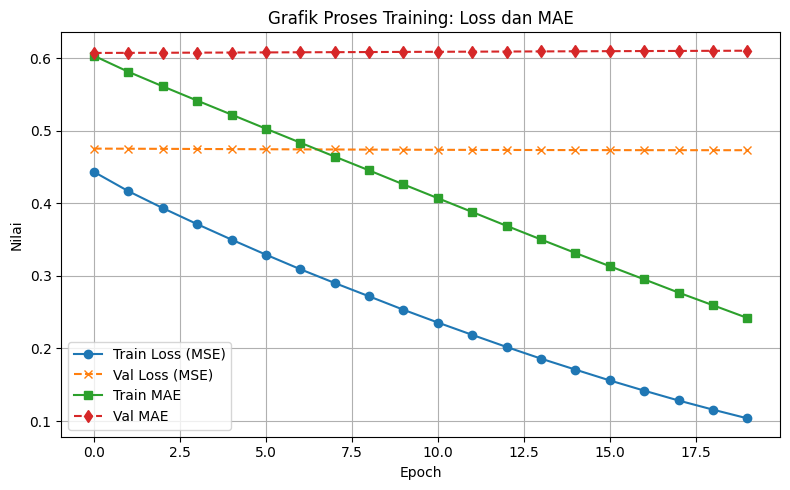

In [ ]:
plt.figure(figsize=(8, 5))

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss (MSE)', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)', linestyle='--', marker='x')

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE', linestyle='-', marker='s')
plt.plot(history.history['val_mae'], label='Val MAE', linestyle='--', marker='d')

# Tambahan styling
plt.title('Grafik Proses Training: Loss dan MAE')
plt.xlabel('Epoch')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Train Loss (MSE): Terlihat menurun secara konsisten, menunjukkan bahwa model belajar dari data pelatihan dengan baik.
- Val Loss (MSE): Relatif konstan di sekitar 0.46, mengindikasikan bahwa model belum mampu meningkatkan performa pada data validasi.
- Train MAE: Menurun secara signifikan, menunjukkan penurunan rata-rata kesalahan absolut selama pelatihan.
- Val MAE: Stabil di sekitar 0.61, menandakan kemungkinan overfitting, karena model tidak memperbaiki kinerjanya terhadap data yang belum dilihat.

mendapatkan place yang belum direview oleh user

In [ ]:
# Salin data utama
# Menggunakan dataset yang sudah digabungkan dan diproses
place_df = dataset.copy()
rating_df = pd.read_csv('rating.csv')

# Buat mapping dari Place_Id asli ke Place_Id yang di-encode
place_to_place_encoded = {original_id: encoded_id for original_id, encoded_id in zip(dataset['Place_Id'], dataset['place_id_enc'])}

# Buat mapping dari User_Id asli ke User_Id yang di-encode
user_to_user_encoded = {original_id: encoded_id for original_id, encoded_id in zip(dataset['User_Id'], dataset['user_id_enc'])}

# Ambil salah satu user secara acak dari rating_df
# Menggunakan nama kolom yang benar 'User_Id'
sample_user = rating_df['User_Id'].sample(1).iloc[0]

# Tempat yang sudah pernah diulas user ini
# Menggunakan nama kolom yang benar 'User_Id' dan 'Place_Id'
reviewed_places = rating_df[rating_df['User_Id'] == sample_user]['Place_Id']

# Ambil daftar tempat yang belum diulas user dari place_df
# Menggunakan nama kolom yang benar 'Place_Id'
unrated_places = place_df[~place_df['Place_Id'].isin(reviewed_places)]['Place_Id']

# Filter hanya tempat yang ada dalam kamus encoded
unrated_places = list(
    set(unrated_places).intersection(set(place_to_place_encoded.keys()))
)

# Encode tempat-tempat yang belum diulas
encoded_unrated_places = [[place_to_place_encoded[p]] for p in unrated_places]

# Encode user ke bentuk integer
encoded_user = user_to_user_encoded.get(sample_user)

# Bentuk array gabungan user-tempat untuk prediksi
user_place_input = np.hstack(
    ([[encoded_user]] * len(encoded_unrated_places), encoded_unrated_places)
)

mendapatkan hasil rekomendasi tempat wisata

In [ ]:
print(f"Menampilkan rekomendasi untuk user: {sample_user}")
print('===' * 9)

# Filter data review khusus untuk user ini, lalu ganti nama kolom supaya konsisten
place_reviewed_by_user = rating_df[rating_df['User_Id'] == sample_user].rename(columns={'Place_Id': 'place_id', 'Place_Ratings': 'rating'})

# Buat mapping dari place_id yang sudah di-encode ke place_id asli
place_encoded_to_place = {enc_id: orig_id for orig_id, enc_id in zip(dataset['Place_Id'], dataset['place_id_enc'])}

# Buat mapping dari place_id asli ke place_id yang sudah di-encode
place_id_to_encoded = dict(zip(dataset['Place_Id'], dataset['place_id_enc']))

# List tempat yang sudah pernah direview user (ID asli)
reviewed_places = place_reviewed_by_user['place_id'].unique()

# Ambil 5 tempat dengan rating tertinggi yang sudah pernah direview user
top_user_places = (
    place_reviewed_by_user.sort_values(by='rating', ascending=False)
    .head(5)
    .place_id.values
)

print("Tempat dengan rating tertinggi dari user:")
if len(top_user_places) == 0:
    print("User belum memberikan rating tinggi pada tempat manapun.")
else:
    for pid in top_user_places:
        name = place_df.loc[place_df['Place_Id'] == pid, 'Place_Name'].values
        if len(name) > 0:
            print(f"- {name[0]}")

print('----' * 8)

# Ambil semua tempat yang ada (dalam bentuk encoded place_id)
all_encoded_places = list(place_encoded_to_place.keys())

# Ambil tempat yang sudah pernah direview user (encoded place_id)
reviewed_encoded_places = [place_id_to_encoded[pid] for pid in reviewed_places if pid in place_id_to_encoded]

# Filter tempat yang belum pernah direview user (encoded place_id)
unrated_encoded_places = [p for p in all_encoded_places if p not in reviewed_encoded_places]

if not unrated_encoded_places:
    print("Tidak ada tempat baru untuk direkomendasikan.")
else:
    # Buat input array untuk model (user_id encoded dan place_id encoded)
    user_array = np.array([[encoded_user]] * len(unrated_encoded_places))
    place_array = np.array([[p] for p in unrated_encoded_places])
    user_place_array = np.hstack((user_array, place_array))

    # Prediksi rating model untuk tempat yang belum direview user
    ratings = model_rekomendasi.predict(user_place_array).flatten()

    # Ambil 10 tempat dengan rating prediksi tertinggi
    top_indices = ratings.argsort()[-10:][::-1]

    # Ambil place_id encoded hasil rekomendasi
    top_recommended_encoded = [unrated_encoded_places[i] for i in top_indices]

    # Konversi kembali ke place_id asli
    top_recommended_original = [place_encoded_to_place.get(enc) for enc in top_recommended_encoded]

    # Ambil data detail tempat rekomendasi dari place_df
    recommended_places = place_df[place_df['Place_Id'].isin(top_recommended_original)]

    print("Top 10 rekomendasi tempat wisata:")
    if recommended_places.empty:
        print("Tidak ditemukan rekomendasi tempat.")
    else:
        # Supaya urutan rekomendasi sesuai dengan hasil prediksi
        details_dict = recommended_places.set_index('Place_Id')['Place_Name'].to_dict()
        for pid in top_recommended_original:
            if pid in details_dict:
                print(f"- {details_dict[pid]}")

print('\n')

Menampilkan rekomendasi untuk user: 75
Tempat dengan rating tertinggi dari user:
- Pulau Pramuka
- Kawasan Wisata Sosrowijayan
- Goa Cerme
- Kota Tua
- Observatorium Bosscha
--------------------------------
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Top 10 rekomendasi tempat wisata:
- La Kana Chapel
- Situs Warungboto
- Museum Tengah Kebun
- Monumen Selamat Datang
- Monumen Sanapati
- The Escape Hunt
- Taman Suropati
- Pemandian Air Panas Ciater
- Taman Situ Lembang
- Curug Aseupan




Sistem rekomendasi berhasil menganalisis preferensi User 75 berdasarkan 5 tempat favorit mereka (mix budaya-sejarah dan alam). 10 rekomendasi baru yang menunjukkan diversifikasi kategori - dari religious sites (La Kana Chapel), museum-monumen (budaya), hingga wisata alam (Curug Aseupan, Pemandian Ciater).